# Statistical Significance Analysis: Confidence Interval Overlaps

This notebook analyzes the overlap of confidence intervals for QWK scores across different guidelines (Mixed, Student, Grader) for a given model and context combination.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the data
df = pd.read_csv('data/ci_wf1_prompt_type.csv', header=[0, 1])
SUFFIX_TYPE = 'W'  # Define the suffix type for consistency

# Clean up the column names
# The first three columns are single-level (Model, Guideline, Context)
# The rest are multi-level with competencies
df.columns = ['_'.join(col).strip('_') if col[1] != '' else col[0] 
              for col in df.columns.values]

df.rename(columns={"Unnamed: 0_level_0_Model": "Model", 
                   " _Guideline": "Guideline",
                   "Unnamed: 1_level_0_Guideline": "Guideline", 
                   " _Context": "Context",
                   "Unnamed: 2_level_0_Context": "Context"}, inplace=True)

# Display the structure
print("Data shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
df.head()

Data shape: (18, 13)

Column names:
['Model', 'Guideline', 'Context', 'C1_W_low', 'C1_W_up', 'C2_W_low', 'C2_W_up', 'C3_W_low', 'C3_W_up', 'C4_W_low', 'C4_W_up', 'C5_W_low', 'C5_W_up']


,Model,Guideline,Context,C1_W_low,C1_W_up,C2_W_low,C2_W_up,C3_W_low,C3_W_up,C4_W_low,C4_W_up,C5_W_low,C5_W_up
0,DeepseekR1,Mixed,essay_only,0.17,0.33,0.01,0.10,0.12,0.26,0.16,0.33,0.25,0.42
1,DeepseekR1,Student,essay_only,0.10,0.24,0.17,0.33,0.25,0.41,0.31,0.48,0.34,0.51
2,DeepseekR1,Grader,essay_only,0.06,0.19,0.00,0.04,0.24,0.40,0.44,0.61,0.30,0.47
3,DeepseekR1,Mixed,full_context,0.01,0.11,0.31,0.50,0.22,0.37,0.37,0.54,0.28,0.46
4,DeepseekR1,Student,full_context,0.02,0.11,0.26,0.44,0.38,0.55,0.28,0.45,0.32,0.49


In [3]:
def plot_confidence_intervals(df, model_name, context_type, competency, suffix="QWK"):
    """
    Plot confidence intervals for a specific model, context, and competency.
    Shows intervals for all guidelines (Mixed, Student, Grader).
    """
    # Filter data for the specified model and context
    filtered_df = df[(df['Model'] == model_name) & (df['Context'] == context_type)]
    
    if filtered_df.empty:
        print(f"No data found for model '{model_name}' with context '{context_type}'")
        return
    
    # Get column names for the specified competency
    low_col = f'{competency}_{suffix}_low'
    up_col = f'{competency}_{suffix}_up'
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define colors for each guideline
    colors = {'Mixed': 'blue', 'Student': 'green', 'Grader': 'red'}
    
    # Plot each guideline
    y_positions = []
    for i, (idx, row) in enumerate(filtered_df.iterrows()):
        guideline = row['Guideline']
        low = row[low_col]
        up = row[up_col]
        mid = (low + up) / 2
        
        # Plot the confidence interval
        ax.plot([low, up], [i, i], 'o-', color=colors[guideline], 
                linewidth=3, markersize=8, label=guideline if i == 0 else "")
        
        # Add the midpoint
        ax.plot(mid, i, 'o', color='black', markersize=6)
        
        # Add text labels
        ax.text(up + 0.02, i, f'{guideline}: [{low:.2f}, {up:.2f}]', 
                verticalalignment='center', fontsize=10)
        
        y_positions.append(i)
    
    # Customize the plot
    ax.set_yticks(y_positions)
    ax.set_yticklabels(filtered_df['Guideline'])
    ax.set_xlabel(f'{suffix} Score', fontsize=12)
    ax.set_ylabel('Guideline', fontsize=12)
    ax.set_title(f'Confidence Intervals for {model_name} - {context_type} - {competency}', 
                 fontsize=14, fontweight='bold')
    
    # Add grid
    ax.grid(True, axis='x', alpha=0.3)
    
    # Set x-axis limits
    ax.set_xlim(-0.2, 1.0)
    
    # Add reference lines
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # Check for overlaps and add annotations
    check_overlaps(filtered_df, low_col, up_col, ax)
    
    plt.tight_layout()
    plt.show()

In [4]:
def check_overlaps(filtered_df, low_col, up_col, ax):
    """
    Check for overlaps between confidence intervals and add annotations.
    """
    guidelines = filtered_df['Guideline'].tolist()
    intervals = [(row[low_col], row[up_col]) for _, row in filtered_df.iterrows()]
    
    overlaps = []
    for i in range(len(intervals)):
        for j in range(i + 1, len(intervals)):
            # Check if intervals overlap
            if (intervals[i][0] <= intervals[j][1] and intervals[j][0] <= intervals[i][1]):
                overlaps.append((guidelines[i], guidelines[j]))
    
    # Add text annotation about overlaps
    if overlaps:
        overlap_text = "Overlapping intervals: " + ", ".join([f"{g1}-{g2}" for g1, g2 in overlaps])
        ax.text(0.02, 0.98, overlap_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    else:
        ax.text(0.02, 0.98, "No overlapping intervals", transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

In [5]:
def analyze_model_context(df, model_name, context_type, suffix):
    """
    Analyze all competencies for a given model and context combination.
    """
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    print(f"\n{'='*60}")
    print(f"Analysis for Model: {model_name}, Context: {context_type}")
    print(f"{'='*60}\n")
    
    for comp in competencies:
        plot_confidence_intervals(df, model_name, context_type, comp, suffix=suffix)

## Example Analysis: DeepseekR1 with essay_only context

Let's analyze the confidence intervals for DeepseekR1 model with essay_only context across all competencies.


Analysis for Model: Sabiá3, Context: full_context



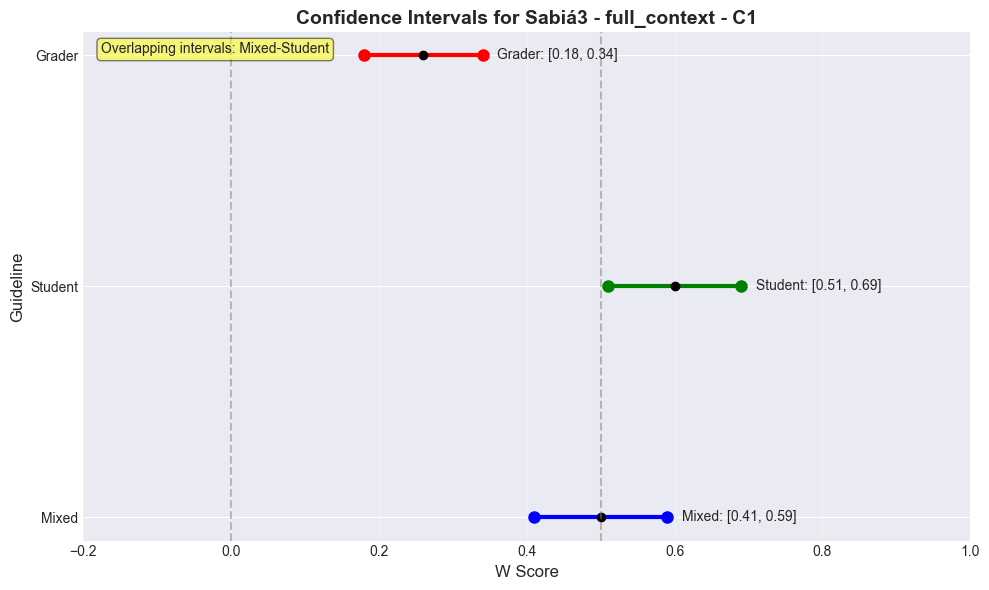

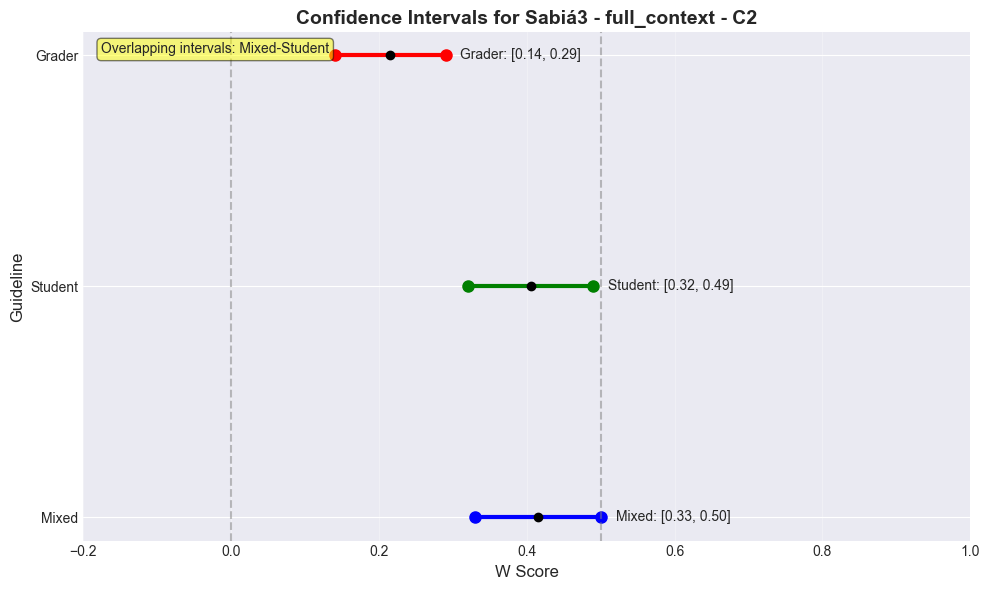

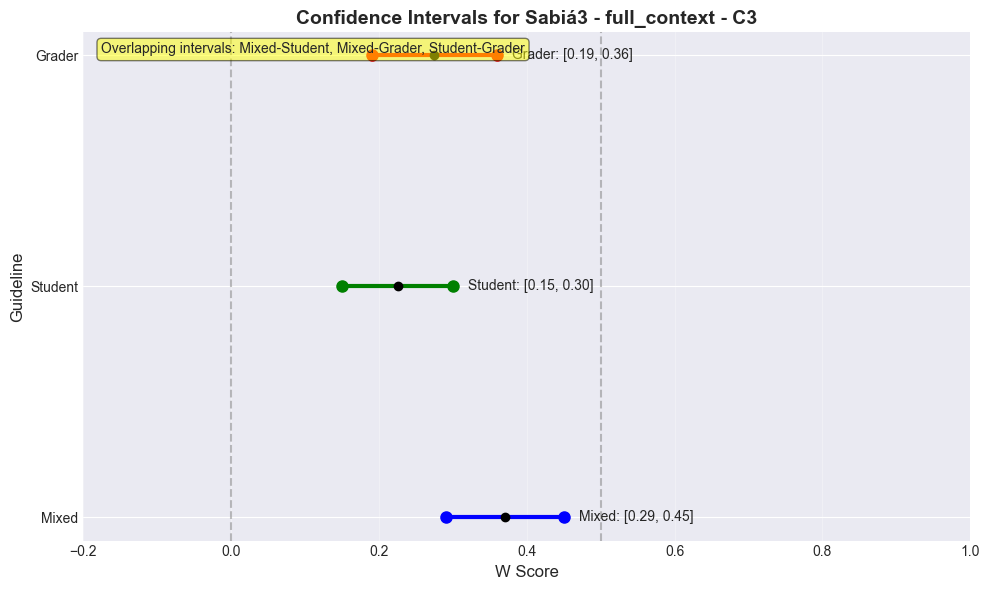

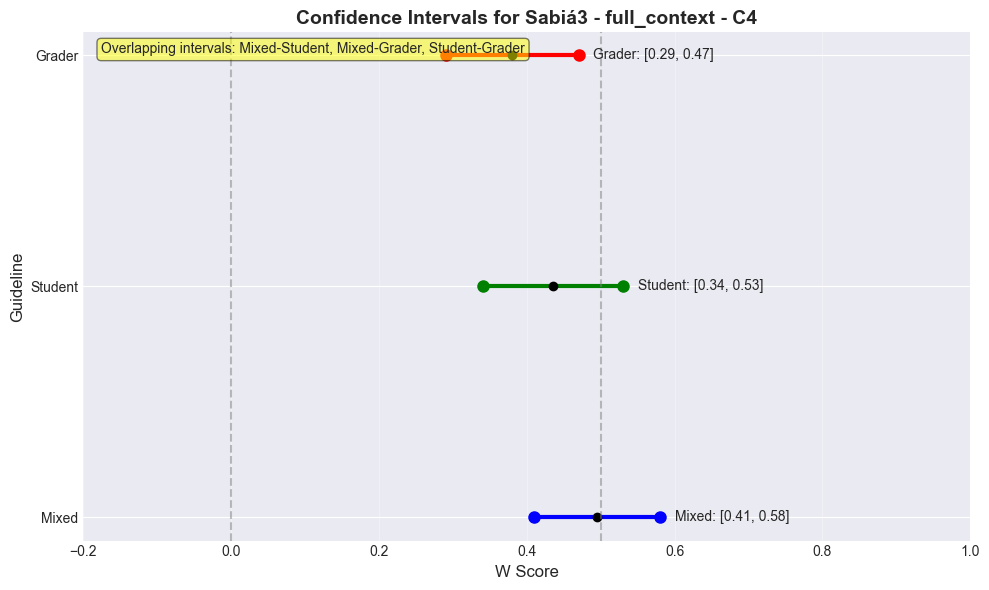

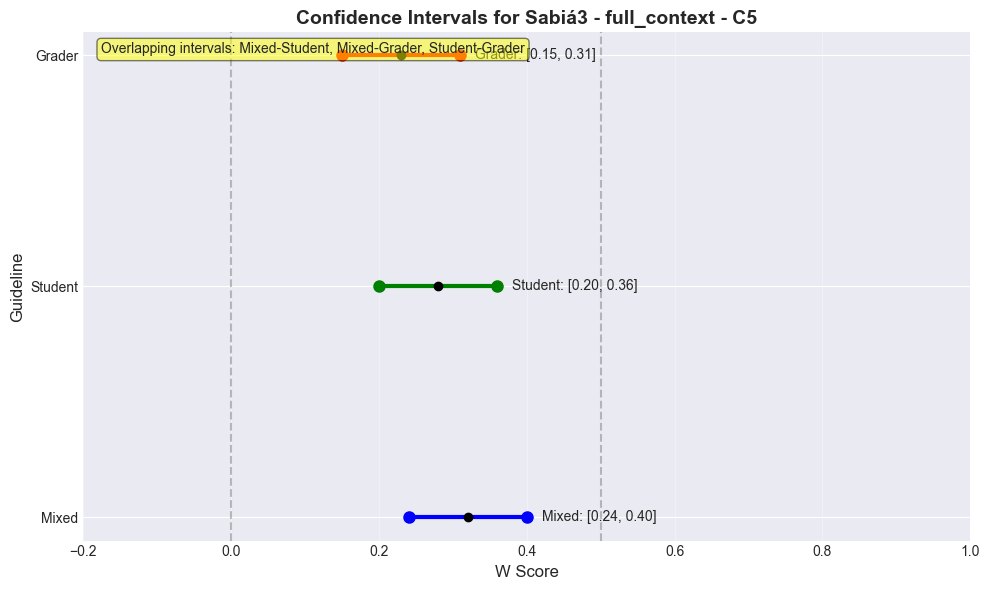

In [16]:
# Analyze DeepseekR1 with essay_only context
analyze_model_context(df, 'Sabiá3', 'full_context', SUFFIX_TYPE)

## Interactive Analysis

You can analyze any model-context combination by specifying the parameters below.

In [7]:
# Get unique models and contexts for reference
print("Available models:", df['Model'].unique().tolist())
print("Available contexts:", df['Context'].unique().tolist())
print("Available guidelines:", df['Guideline'].unique().tolist())

Available models: ['DeepseekR1', 'GPT4o', 'Sabiá3']
Available contexts: ['essay_only', 'full_context']
Available guidelines: ['Mixed', 'Student', 'Grader']



Analysis for Model: DeepseekR1, Context: full_context



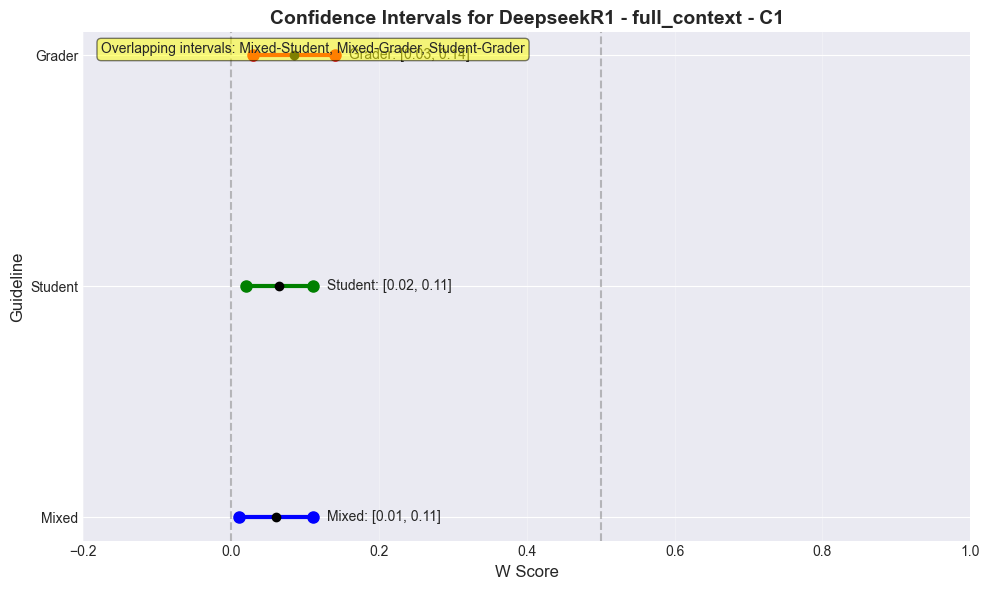

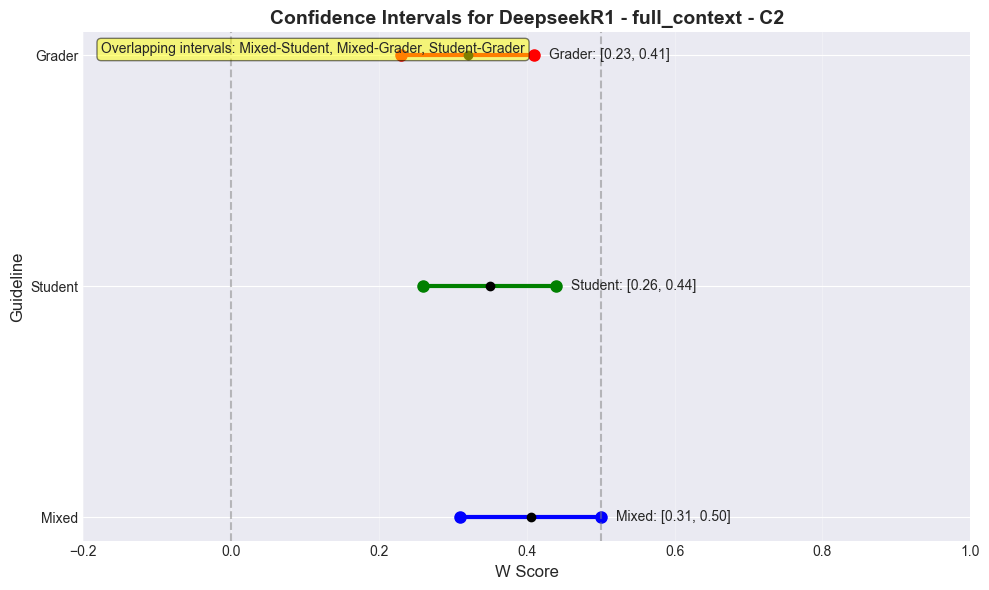

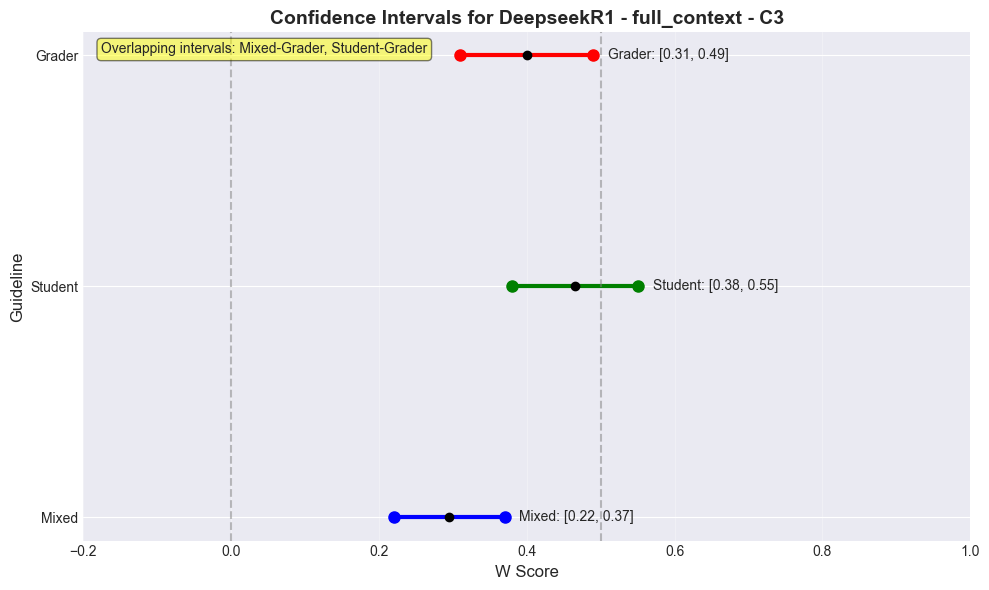

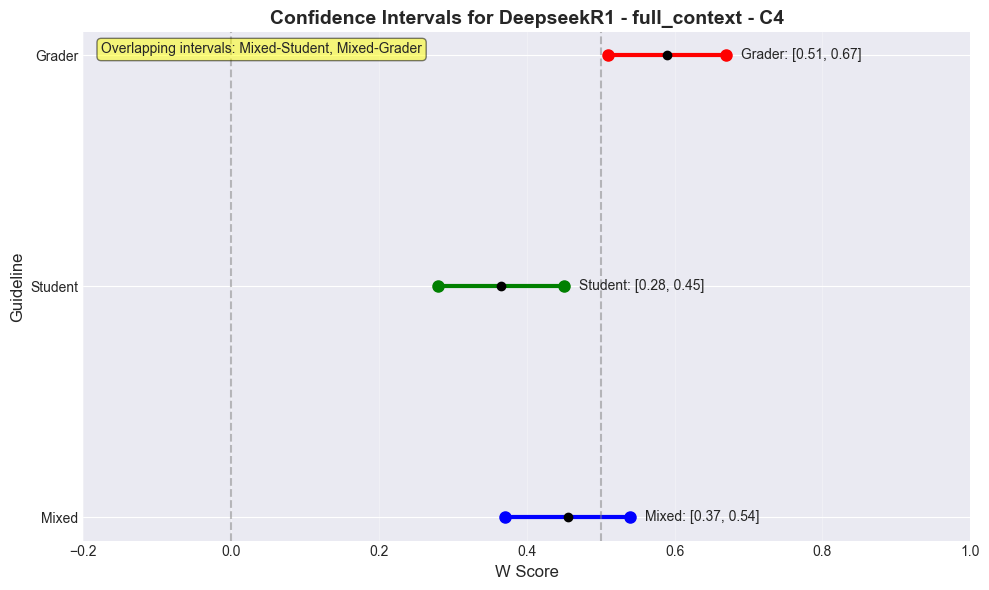

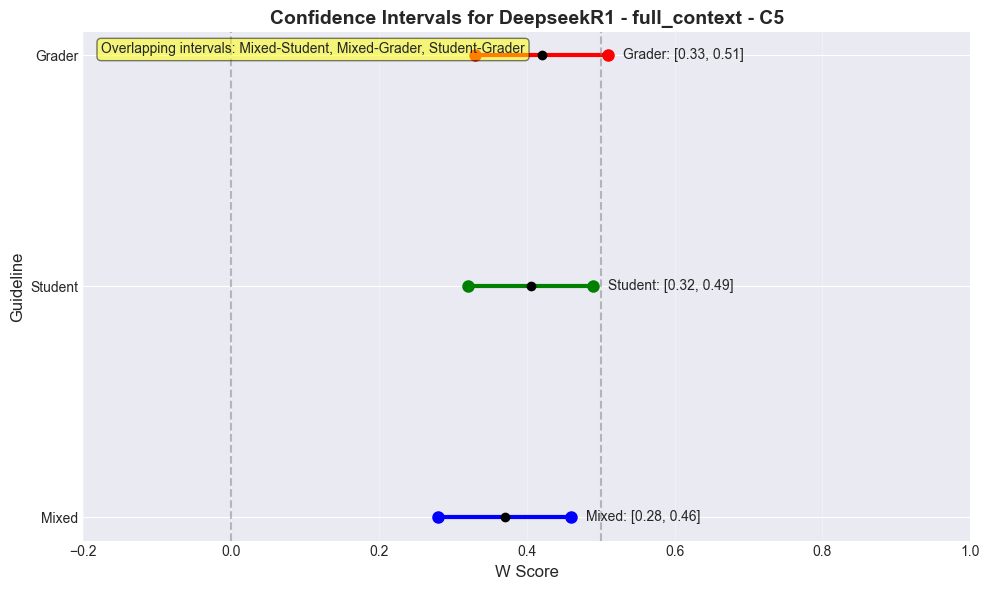

In [8]:
# Example: Analyze another combination
# Change these parameters to analyze different combinations
model_to_analyze = 'DeepseekR1'
context_to_analyze = 'full_context'

analyze_model_context(df, model_to_analyze, context_to_analyze, SUFFIX_TYPE)

## Summary Statistics

Let's create a summary table showing which guideline combinations have overlapping confidence intervals for each model-context-competency combination.

In [9]:
def create_overlap_summary(df):
    """
    Create a summary of all overlapping confidence intervals.
    """
    results = []
    
    models = df['Model'].unique()
    contexts = df['Context'].unique()
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    for model in models:
        for context in contexts:
            for comp in competencies:
                filtered_df = df[(df['Model'] == model) & (df['Context'] == context)]
                
                if not filtered_df.empty:
                    low_col = f'{comp}_{SUFFIX_TYPE}_low'
                    up_col = f'{comp}_{SUFFIX_TYPE}_up'
                    
                    guidelines = filtered_df['Guideline'].tolist()
                    intervals = [(row[low_col], row[up_col]) for _, row in filtered_df.iterrows()]
                    
                    # Check all pairs for overlaps
                    overlap_pairs = []
                    for i in range(len(intervals)):
                        for j in range(i + 1, len(intervals)):
                            if (intervals[i][0] <= intervals[j][1] and intervals[j][0] <= intervals[i][1]):
                                overlap_pairs.append(f"{guidelines[i]}-{guidelines[j]}")
                    
                    results.append({
                        'Model': model,
                        'Context': context,
                        'Competency': comp,
                        'Has_Overlaps': len(overlap_pairs) > 0,
                        'Overlap_Pairs': ', '.join(overlap_pairs) if overlap_pairs else 'None'
                    })
    
    return pd.DataFrame(results)

# Create and display the summary
overlap_summary = create_overlap_summary(df)
print("Overlap Summary:")
print(f"Total combinations analyzed: {len(overlap_summary)}")
print(f"Combinations with overlaps: {overlap_summary['Has_Overlaps'].sum()}")
print(f"Percentage with overlaps: {overlap_summary['Has_Overlaps'].mean()*100:.1f}%")

# Show a sample of the summary
overlap_summary

Overlap Summary:
Total combinations analyzed: 30
Combinations with overlaps: 30
Percentage with overlaps: 100.0%


,Model,Context,Competency,Has_Overlaps,Overlap_Pairs
0,DeepseekR1,essay_only,C1,True,"Mixed-Student, Mixed-Grader, Student-Grader"
1,DeepseekR1,essay_only,C2,True,Mixed-Grader
2,DeepseekR1,essay_only,C3,True,"Mixed-Student, Mixed-Grader, Student-Grader"
3,DeepseekR1,essay_only,C4,True,"Mixed-Student, Student-Grader"
4,DeepseekR1,essay_only,C5,True,"Mixed-Student, Mixed-Grader, Student-Grader"
5,DeepseekR1,full_context,C1,True,"Mixed-Student, Mixed-Grader, Student-Grader"
6,DeepseekR1,full_context,C2,True,"Mixed-Student, Mixed-Grader, Student-Grader"
7,DeepseekR1,full_context,C3,True,"Mixed-Grader, Student-Grader"
8,DeepseekR1,full_context,C4,True,"Mixed-Student, Mixed-Grader"
9,DeepseekR1,full_context,C5,True,"Mixed-Student, Mixed-Grader, Student-Grader"


In [10]:
def create_guideline_overlap_matrix(df, model_name, context_type, suffix='QWK'):
    """
    Create a matrix showing which guidelines have overlapping confidence intervals for each competency
    for a specific model and context combination.
    """
    # Filter data for the specified model and context
    filtered_df = df[(df['Model'] == model_name) & (df['Context'] == context_type)]
    
    if filtered_df.empty:
        print(f"No data found for model '{model_name}' with context '{context_type}'")
        return
    
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    guidelines = filtered_df['Guideline'].tolist()
    
    # Create a figure with subplots for each competency
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, comp in enumerate(competencies):
        low_col = f'{comp}_{suffix}_low'
        up_col = f'{comp}_{suffix}_up'
        
        # Create overlap matrix
        n_guidelines = len(guidelines)
        overlap_matrix = np.zeros((n_guidelines, n_guidelines))
        
        for i in range(n_guidelines):
            for j in range(n_guidelines):
                if i == j:
                    overlap_matrix[i, j] = 1
                else:
                    # Check if intervals overlap
                    if (filtered_df.iloc[i][low_col] <= filtered_df.iloc[j][up_col] and 
                        filtered_df.iloc[j][low_col] <= filtered_df.iloc[i][up_col]):
                        overlap_matrix[i, j] = 1
        
        # Plot heatmap
        ax = axes[idx]
        sns.heatmap(overlap_matrix, 
                    xticklabels=guidelines,
                    yticklabels=guidelines,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=1,
                    square=True,
                    cbar=False,
                    ax=ax,
                    annot=True,
                    fmt='.0f')
        ax.set_title(f'{comp}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        
    plt.suptitle(f'Guideline Overlap Matrix for {model_name} - {context_type}\n(red = overlapping/no statistical difference)', fontsize=16)
    plt.tight_layout()
    plt.show()

## Guideline Overlap Matrix Visualization

Let's visualize the overlap between guidelines using a matrix representation for each competency.

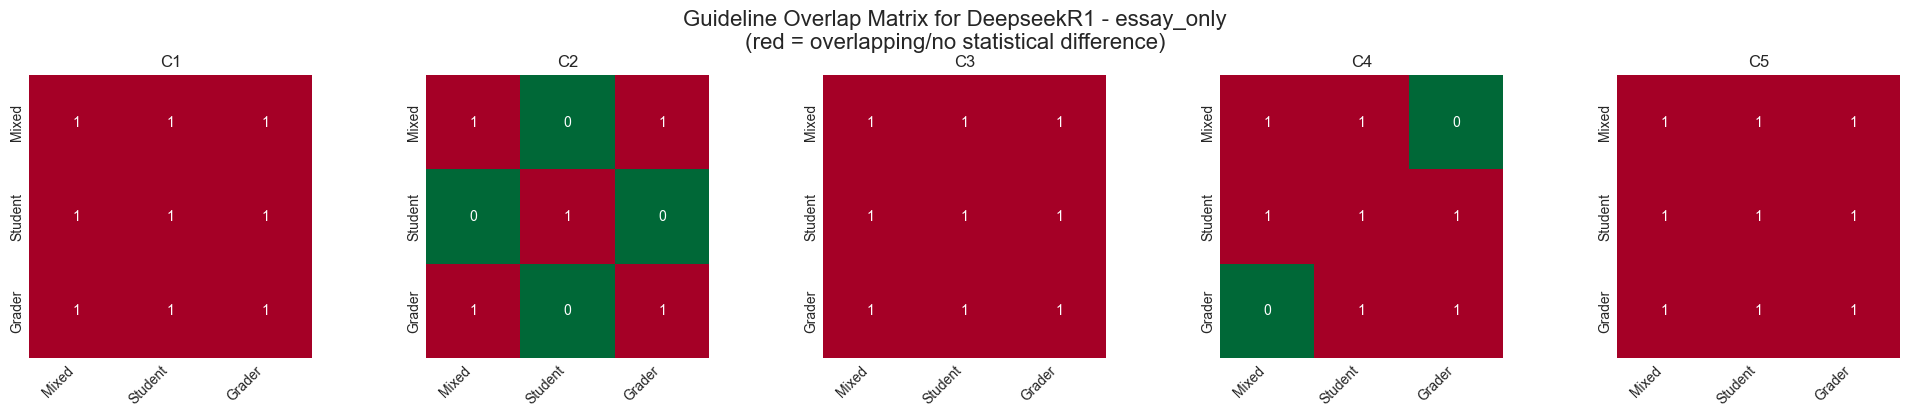

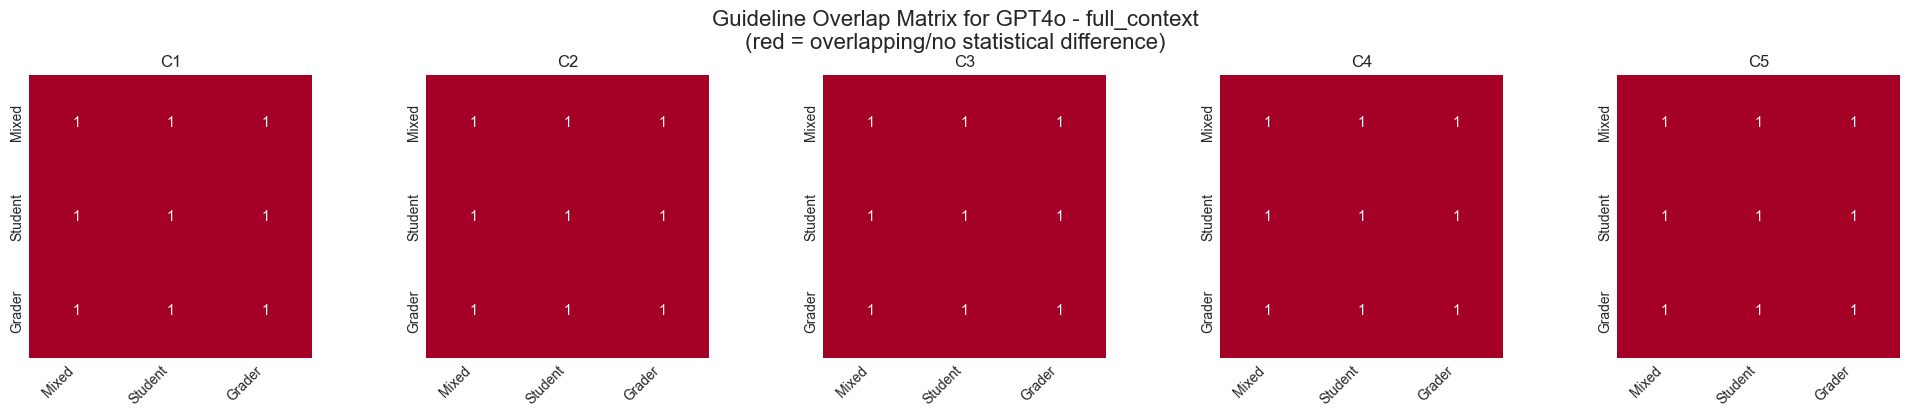

In [11]:
# Create overlap matrix for DeepseekR1 with essay_only context
create_guideline_overlap_matrix(df, 'DeepseekR1', 'essay_only', SUFFIX_TYPE)

# Create overlap matrix for another model-context combination
create_guideline_overlap_matrix(df, 'GPT4o', 'full_context', SUFFIX_TYPE)

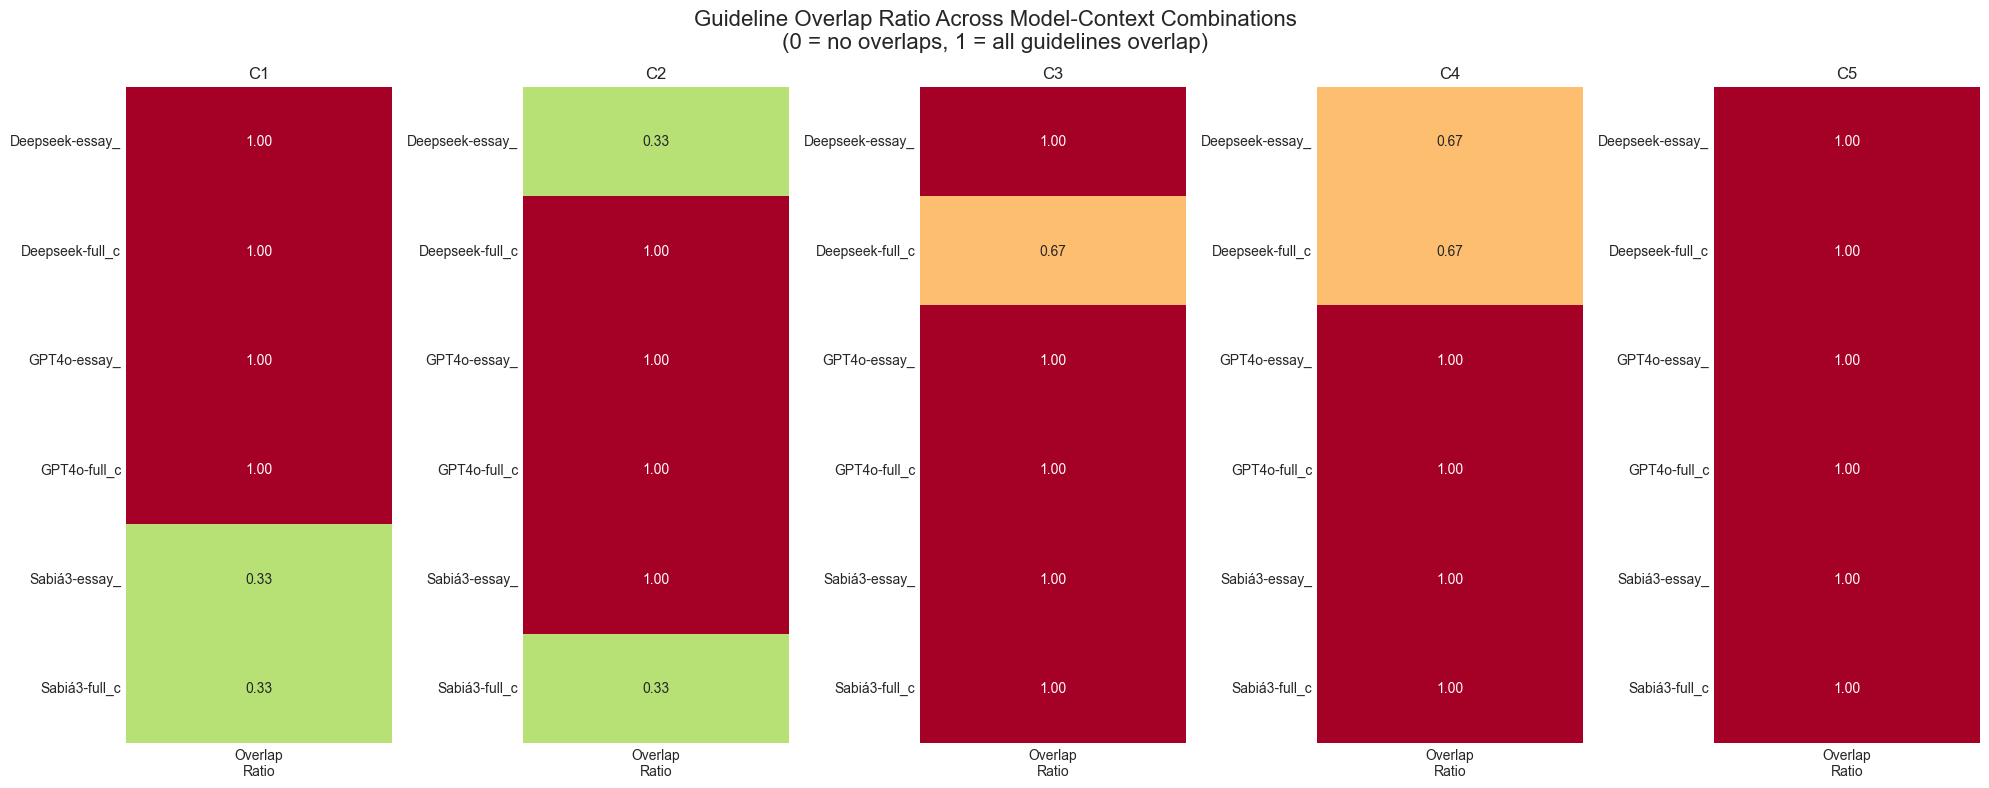

In [12]:
def create_comprehensive_guideline_overlap_summary(df, suffix='QWK'):
    """
    Create a comprehensive visualization showing guideline overlap patterns across all model-context combinations.
    """
    models = df['Model'].unique()
    contexts = df['Context'].unique()
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    # Create a figure with subplots for each competency
    fig, axes = plt.subplots(1, 5, figsize=(20, 8))
    
    for idx, comp in enumerate(competencies):
        low_col = f'{comp}_{suffix}_low'
        up_col = f'{comp}_{suffix}_up'
        
        # Create data for heatmap
        overlap_data = []
        y_labels = []
        
        for model in models:
            for context in contexts:
                # Get guidelines for this model-context combination
                model_context_df = df[(df['Model'] == model) & (df['Context'] == context)]
                
                if len(model_context_df) == 3:  # Should have Mixed, Student, Grader
                    # Count overlaps between guidelines
                    overlap_count = 0
                    total_pairs = 0
                    
                    for i in range(len(model_context_df)):
                        for j in range(i + 1, len(model_context_df)):
                            total_pairs += 1
                            # Check if intervals overlap
                            if (model_context_df.iloc[i][low_col] <= model_context_df.iloc[j][up_col] and 
                                model_context_df.iloc[j][low_col] <= model_context_df.iloc[i][up_col]):
                                overlap_count += 1
                    
                    # Calculate overlap percentage
                    overlap_percentage = overlap_count / total_pairs if total_pairs > 0 else 0
                    overlap_data.append(overlap_percentage)
                    y_labels.append(f"{model[:8]}-{context[:6]}")
        
        # Convert to matrix (single column)
        overlap_matrix = np.array(overlap_data).reshape(-1, 1)
        
        # Plot heatmap
        ax = axes[idx]
        sns.heatmap(overlap_matrix, 
                    xticklabels=['Overlap\nRatio'],
                    yticklabels=y_labels,
                    cmap='RdYlGn_r',
                    vmin=0, vmax=1,
                    cbar=False,
                    ax=ax,
                    annot=True,
                    fmt='.2f')
        ax.set_title(f'{comp}')
        
    plt.suptitle('Guideline Overlap Ratio Across Model-Context Combinations\n(0 = no overlaps, 1 = all guidelines overlap)', 
                 fontsize=16)
    plt.tight_layout()
    plt.show()
    
# Create comprehensive overlap summary
create_comprehensive_guideline_overlap_summary(df, SUFFIX_TYPE)

Guideline Overlap Pattern Analysis

Total combinations analyzed: 30

Overlap frequencies:
Mixed-Student overlaps: 27 (90.0%)
Mixed-Grader overlaps: 27 (90.0%)
Student-Grader overlaps: 25 (83.3%)
All guidelines overlap: 23 (76.7%)


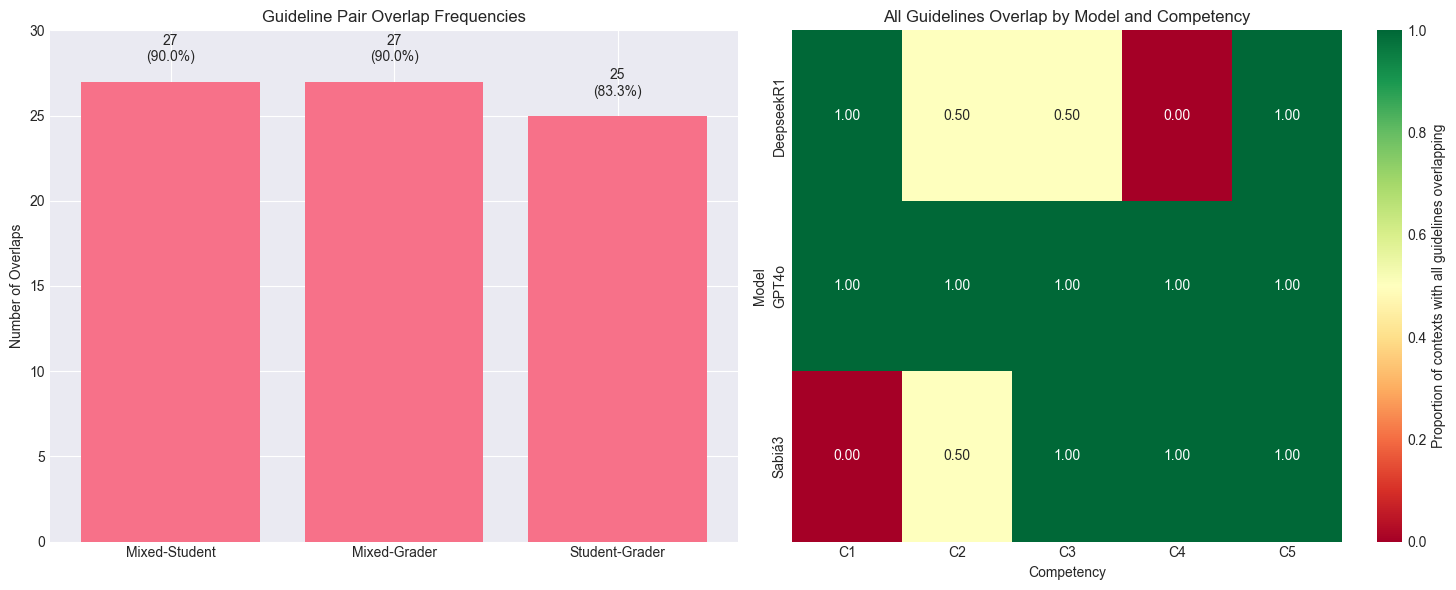

In [13]:
def analyze_guideline_overlap_patterns(df, suffix='QWK'):
    """
    Analyze and report detailed patterns of guideline overlaps.
    """
    models = df['Model'].unique()
    contexts = df['Context'].unique()
    competencies = ['C1', 'C2', 'C3', 'C4', 'C5']
    
    results = []
    
    for model in models:
        for context in contexts:
            model_context_df = df[(df['Model'] == model) & (df['Context'] == context)]
            
            if len(model_context_df) == 3:  # Should have Mixed, Student, Grader
                for comp in competencies:
                    low_col = f'{comp}_{suffix}_low'
                    up_col = f'{comp}_{suffix}_up'
                    
                    # Check specific pairs
                    guidelines = model_context_df['Guideline'].tolist()
                    mixed_idx = guidelines.index('Mixed')
                    student_idx = guidelines.index('Student')
                    grader_idx = guidelines.index('Grader')
                    
                    # Check Mixed-Student overlap
                    mixed_student_overlap = (
                        model_context_df.iloc[mixed_idx][low_col] <= model_context_df.iloc[student_idx][up_col] and 
                        model_context_df.iloc[student_idx][low_col] <= model_context_df.iloc[mixed_idx][up_col]
                    )
                    
                    # Check Mixed-Grader overlap
                    mixed_grader_overlap = (
                        model_context_df.iloc[mixed_idx][low_col] <= model_context_df.iloc[grader_idx][up_col] and 
                        model_context_df.iloc[grader_idx][low_col] <= model_context_df.iloc[mixed_idx][up_col]
                    )
                    
                    # Check Student-Grader overlap
                    student_grader_overlap = (
                        model_context_df.iloc[student_idx][low_col] <= model_context_df.iloc[grader_idx][up_col] and 
                        model_context_df.iloc[grader_idx][low_col] <= model_context_df.iloc[student_idx][up_col]
                    )
                    
                    results.append({
                        'Model': model,
                        'Context': context,
                        'Competency': comp,
                        'Mixed-Student': mixed_student_overlap,
                        'Mixed-Grader': mixed_grader_overlap,
                        'Student-Grader': student_grader_overlap,
                        'All_Overlap': mixed_student_overlap and mixed_grader_overlap and student_grader_overlap
                    })
    
    # Create summary dataframe
    results_df = pd.DataFrame(results)
    
    # Print summary statistics
    print("Guideline Overlap Pattern Analysis")
    print("="*60)
    print(f"\nTotal combinations analyzed: {len(results_df)}")
    print(f"\nOverlap frequencies:")
    print(f"Mixed-Student overlaps: {results_df['Mixed-Student'].sum()} ({results_df['Mixed-Student'].mean()*100:.1f}%)")
    print(f"Mixed-Grader overlaps: {results_df['Mixed-Grader'].sum()} ({results_df['Mixed-Grader'].mean()*100:.1f}%)")
    print(f"Student-Grader overlaps: {results_df['Student-Grader'].sum()} ({results_df['Student-Grader'].mean()*100:.1f}%)")
    print(f"All guidelines overlap: {results_df['All_Overlap'].sum()} ({results_df['All_Overlap'].mean()*100:.1f}%)")
    
    # Create visualization of overlap patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart of overlap frequencies by pair
    overlap_counts = [
        results_df['Mixed-Student'].sum(),
        results_df['Mixed-Grader'].sum(),
        results_df['Student-Grader'].sum()
    ]
    pairs = ['Mixed-Student', 'Mixed-Grader', 'Student-Grader']
    
    bars = ax1.bar(pairs, overlap_counts)
    ax1.set_ylabel('Number of Overlaps')
    ax1.set_title('Guideline Pair Overlap Frequencies')
    ax1.set_ylim(0, len(results_df))
    
    # Add percentage labels on bars
    for bar, count in zip(bars, overlap_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}\n({count/len(results_df)*100:.1f}%)',
                ha='center', va='bottom')
    
    # Heatmap of overlap patterns by model and competency
    pivot_data = results_df.pivot_table(
        values='All_Overlap',
        index='Model',
        columns='Competency',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.2f',
                cmap='RdYlGn',
                vmin=0, vmax=1,
                ax=ax2,
                cbar_kws={'label': 'Proportion of contexts with all guidelines overlapping'})
    ax2.set_title('All Guidelines Overlap by Model and Competency')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Analyze guideline overlap patterns
overlap_patterns_df = analyze_guideline_overlap_patterns(df, SUFFIX_TYPE)